# Comparing standard normal CDFs approximations 

As the title suggests, the point of this notebook is to compare the values of our std norm CDF to the values of other cairo implementations of the approximation and the values form SciPy(python package).

Due to floating point arithmetic, SciPy returns precise values only for negative xs and for higher positive xs will return just 1. For this reason, only negative xs are shown, as values for positive xs can be expressed as 1-f(x) where x is negative number. 

## Table of Contents:
* [Deploying contracts](#Deploying-contracts)
* [Calling the contracts](#Calling-the-contracts)
* [Plots of absolute erorrs](#Plots-of-absolute-erorrs)
* [Plots of relative errors](#Plots-of-relative-errors)
* [Relative errors at values != 0](#Relative-errors-at-values-!=-0)
* [Our contract only](#Our-contract-only)


In [1]:
import os
import math
import pickle

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm 

from starkware.starknet.testing.starknet import Starknet

### Deploying contracts

In [2]:
# The path to the contract source code

# Our Contract
TESTABLE_CONTRACT_FILE = os.path.join("tests", "testable_option_pricing.cairo")

# Other contracts written in cairo:

# https://github.com/araghava/cairo-black-scholes/blob/main/black_scholes_contract.cairo
CONTR_FILE_2 = os.path.join(".", "black_scholes_contract.cairo")

# https://github.com/Janmajayamall/BlackScholes-cairo/blob/main/contracts/blackscholes.cairo
CONTR_FILE_3 = os.path.join(".", "bs.cairo")

Math64x61_FRACT_PART = 2 ** 61

In [13]:
# Start the network and deploy contracts 
net = await Starknet.empty()

contract = await net.deploy(source = TESTABLE_CONTRACT_FILE, cairo_path = ['../../'])
contract_2 = await net.deploy(source = CONTR_FILE_2, cairo_path = ['../../'])
contract_3 = await net.deploy(source = CONTR_FILE_3, cairo_path = ['../../'])

### Calling the contracts

In [ ]:
# Generate list of x values

std = {}
std['xs'] = [i / 10 for i in range(-300, 1)]
std['xs'].remove(0) 

In [ ]:
# Generating numbers from python and cairo
# The numbers are generated only for negative x

std['sci_py'] = [norm.cdf(i) for i in std['xs']]

std['cairo'] = {}
std['cairo']['our'] = []
std['cairo']['second'] = []
std['cairo']['third'] = []

a = len(std['xs'])

for ix, x in enumerate(std['xs']):
    try:
        if ix % 5 == 0:
            print(f'{ix} out of {a} done.')
        num_our = int(x * Math64x61_FRACT_PART)
        num_2_3 = int(x * 10**27)

        res_our = await contract.testable_std_normal_cdf(x = num_our).call()
        res_2 = await contract_2.std_normal_cdf(x = num_2_3).call()
        res_3 = await contract_3.std_normal_cdf(x = num_2_3).call()

        std['cairo']['our'].append(res_our.result[0])
        std['cairo']['second'].append(res_2.result[0])
        std['cairo']['third'].append(res_3.result[0])
    except:
        !spd-say "ERROR ERROR ERROR"
        raise SystemExit
!spd-say "DONE DONE DONE"

#### Notes

 - contract_2 ->  Fails when including zero. 

 - contract_3 -> Will return an error when inputing 'x' that is higher than approx. 7. ( multiplied by 10^27 as that is the multiplier used for precision)

<!--  Little easter egg :)  -->

In [3]:
# It can take quite a while for the data to load, so the original data is provided in a pickle file

# with open('std_norm.pickle', 'wb') as f:
#     pickle.dump(std, f)

# with open('std_norm.pickle', 'rb') as f:
#     std = pickle.load(f)

### Plots of absolute erorrs 

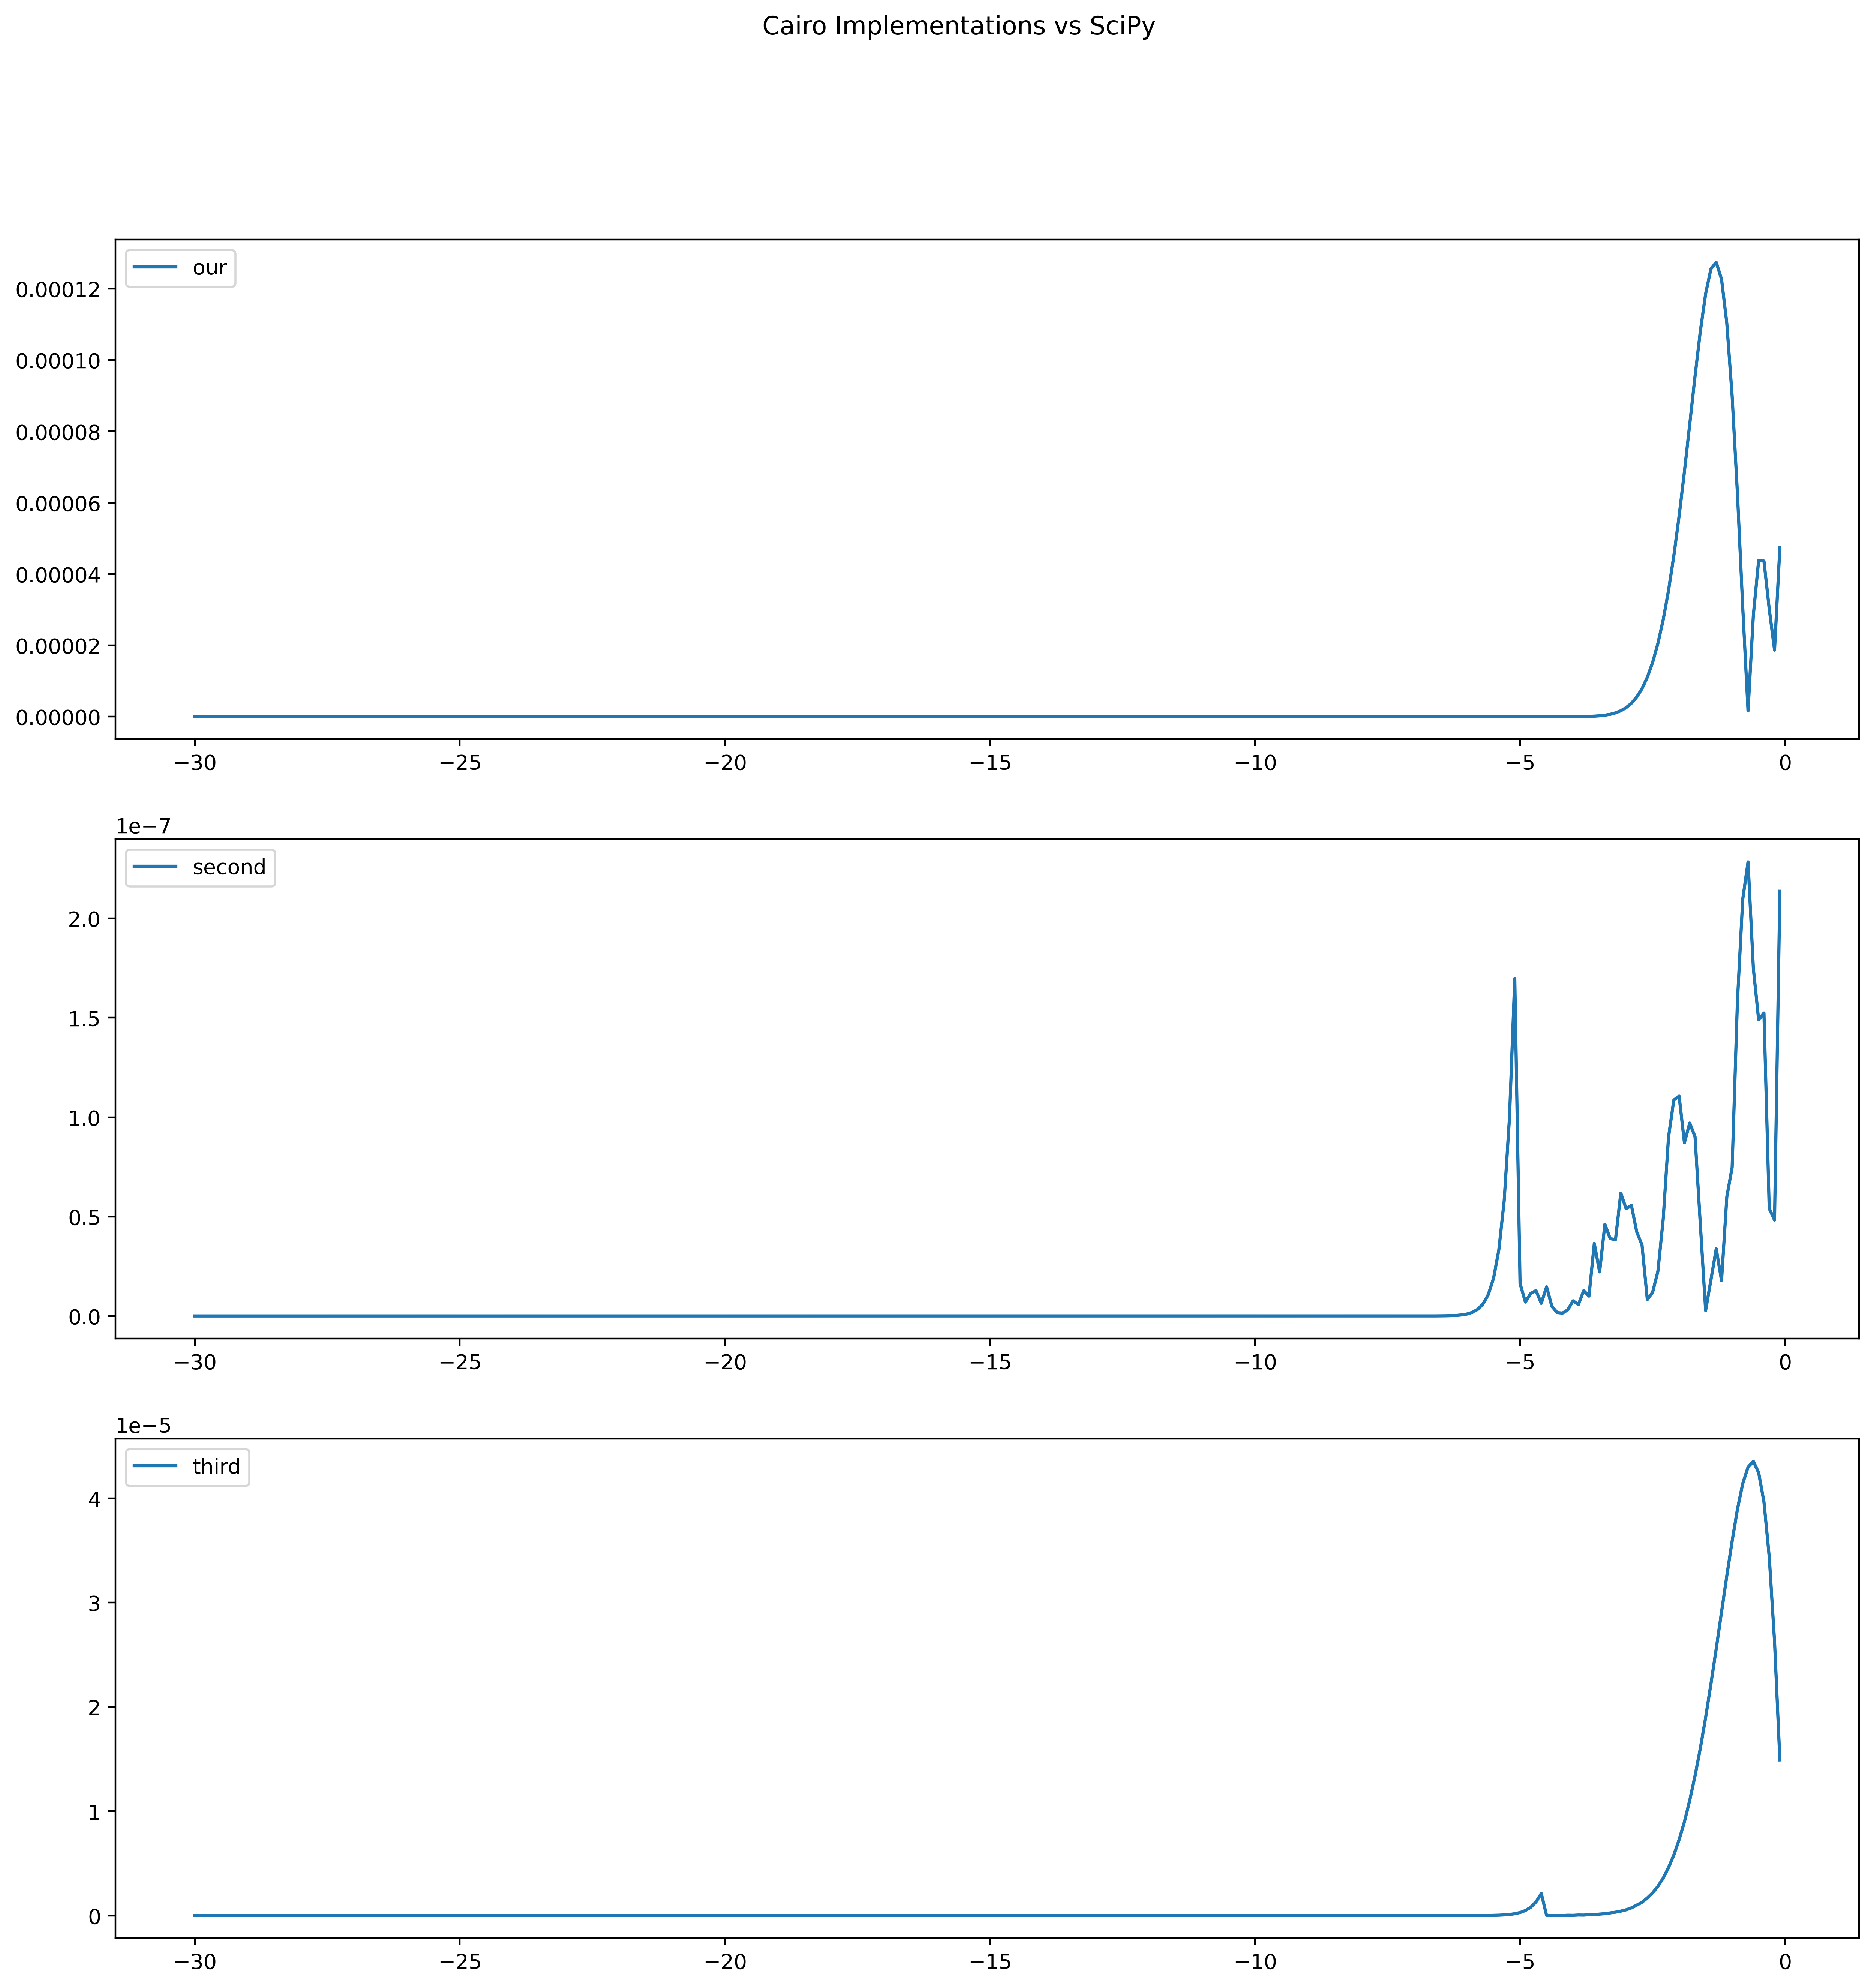

In [5]:
fig, ax = plt.subplots(ncols = 1, nrows = 3)
fig.set_dpi(400)
fig.set_size_inches(15, 15)
fig.suptitle("Cairo Implementations vs SciPy")

for cix, (ckey, cvals) in enumerate(std['cairo'].items()):
    if ckey == 'our':
        tmp = [abs(p - (c / 2**61)) for p, c in zip(std['sci_py'], cvals)]
    else:
        tmp = [abs(p - (c / 10**27)) for p, c in zip(std['sci_py'], cvals)]

    ax[cix].plot(std['xs'], tmp, label = ckey)
    ax[cix].legend(loc = 'upper left')

In [6]:
for cix, (ckey, cvals) in enumerate(std['cairo'].items()):
    if ckey == 'our':
        tmp = [abs(p - (c / 2**61)) for p, c in zip(std['sci_py'], cvals)]
    else:
        tmp = [abs(p - (c / 10**27)) for p, c in zip(std['sci_py'], cvals)]
        
    print(f'{ckey} mean: {np.mean(tmp)}')
    print(f'{ckey} max: {np.max(tmp)}')
    print(f'{ckey} min: {np.min(tmp)}')
    print('-----------------------------------------------------')

our mean: 5.298586340618491e-06
our max: 0.0001274255038576505
our min: 4.906713927147908e-198
-----------------------------------------------------
second mean: 1.0891053553171443e-08
second max: 2.2843959304741368e-07
second min: 4.906713927147908e-198
-----------------------------------------------------
third mean: 1.9229503819729134e-06
third max: 4.35508992863709e-05
third min: 4.906713927147908e-198
-----------------------------------------------------


### Plots of relative errors

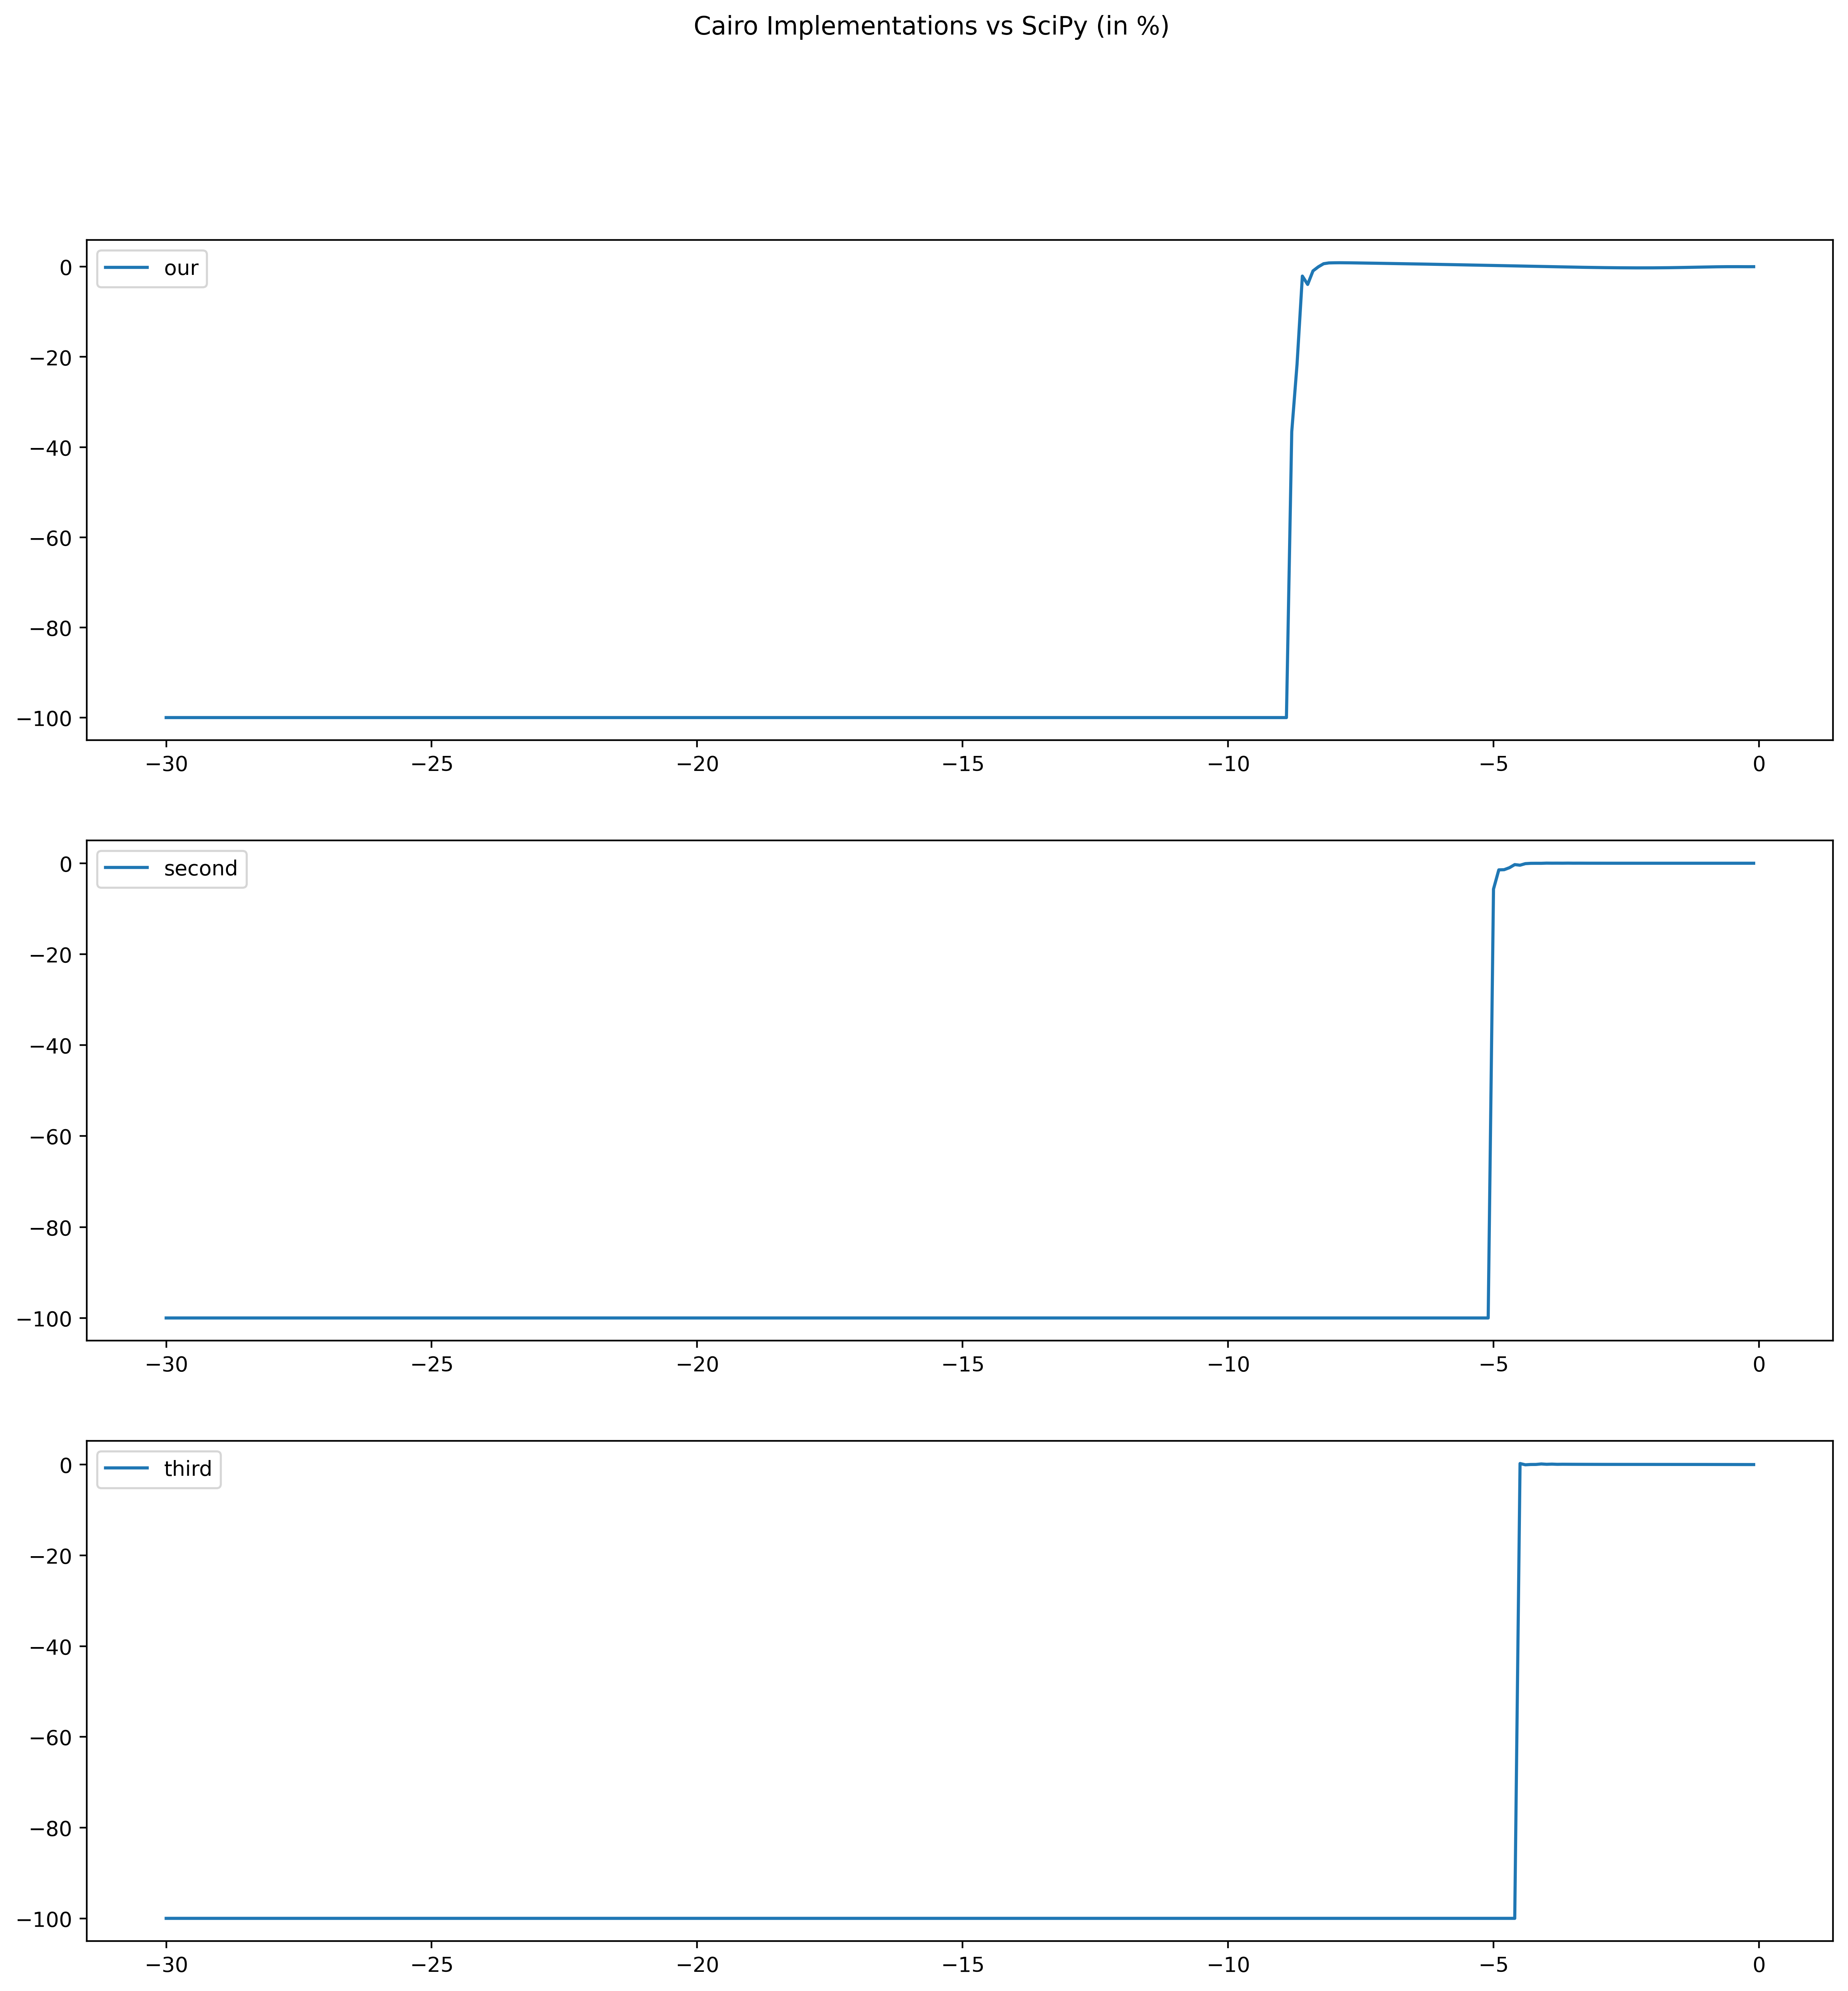

In [9]:
fig, ax = plt.subplots(ncols = 1, nrows = 3)
fig.set_dpi(400)
fig.set_size_inches(15, 15)
fig.suptitle("Cairo Implementations vs SciPy (in %)")

for cix, (ckey, cvals) in enumerate(std['cairo'].items()):
    if ckey == 'our':
        tmp = [(c / (p * 2 ** 61) - 1) * 100 for p, c in zip(std['sci_py'], cvals)]
    else:
        tmp = [(c / (p * 10 ** 27) - 1 ) * 100 for p, c in zip(std['sci_py'], cvals)]

    ax[cix].plot(std['xs'], tmp, label = ckey)
    ax[cix].legend(loc = 'upper left')

In [8]:
for cix, (ckey, cvals) in enumerate(std['cairo'].items()):
    if ckey == 'our':
        tmp = [(c / (p * 2 ** 61) - 1) for p, c in zip(std['sci_py'], cvals)]
    else:
        tmp = [(c / (p * 10 ** 27) - 1 ) for p, c in zip(std['sci_py'], cvals)]
        
    print(f'{ckey} mean: {np.mean(tmp):%}')
    print(f'{ckey} max: {np.max(tmp):%}')
    print(f'{ckey} min: {np.min(tmp):%}')
    print('-----------------------------------------------------')

our mean: -70.826983%
our max: 0.885152%
our min: -100.000000%
-----------------------------------------------------
second mean: -83.367580%
second max: 0.024062%
second min: -100.000000%
-----------------------------------------------------
third mean: -84.994140%
third max: 0.233485%
third min: -100.000000%
-----------------------------------------------------


The fact that the contracts return 0 after a certain value skews the results of non-zero values. Plots and stats for errors at values not equal to zero can be found below.

### Relative errors at values != 0

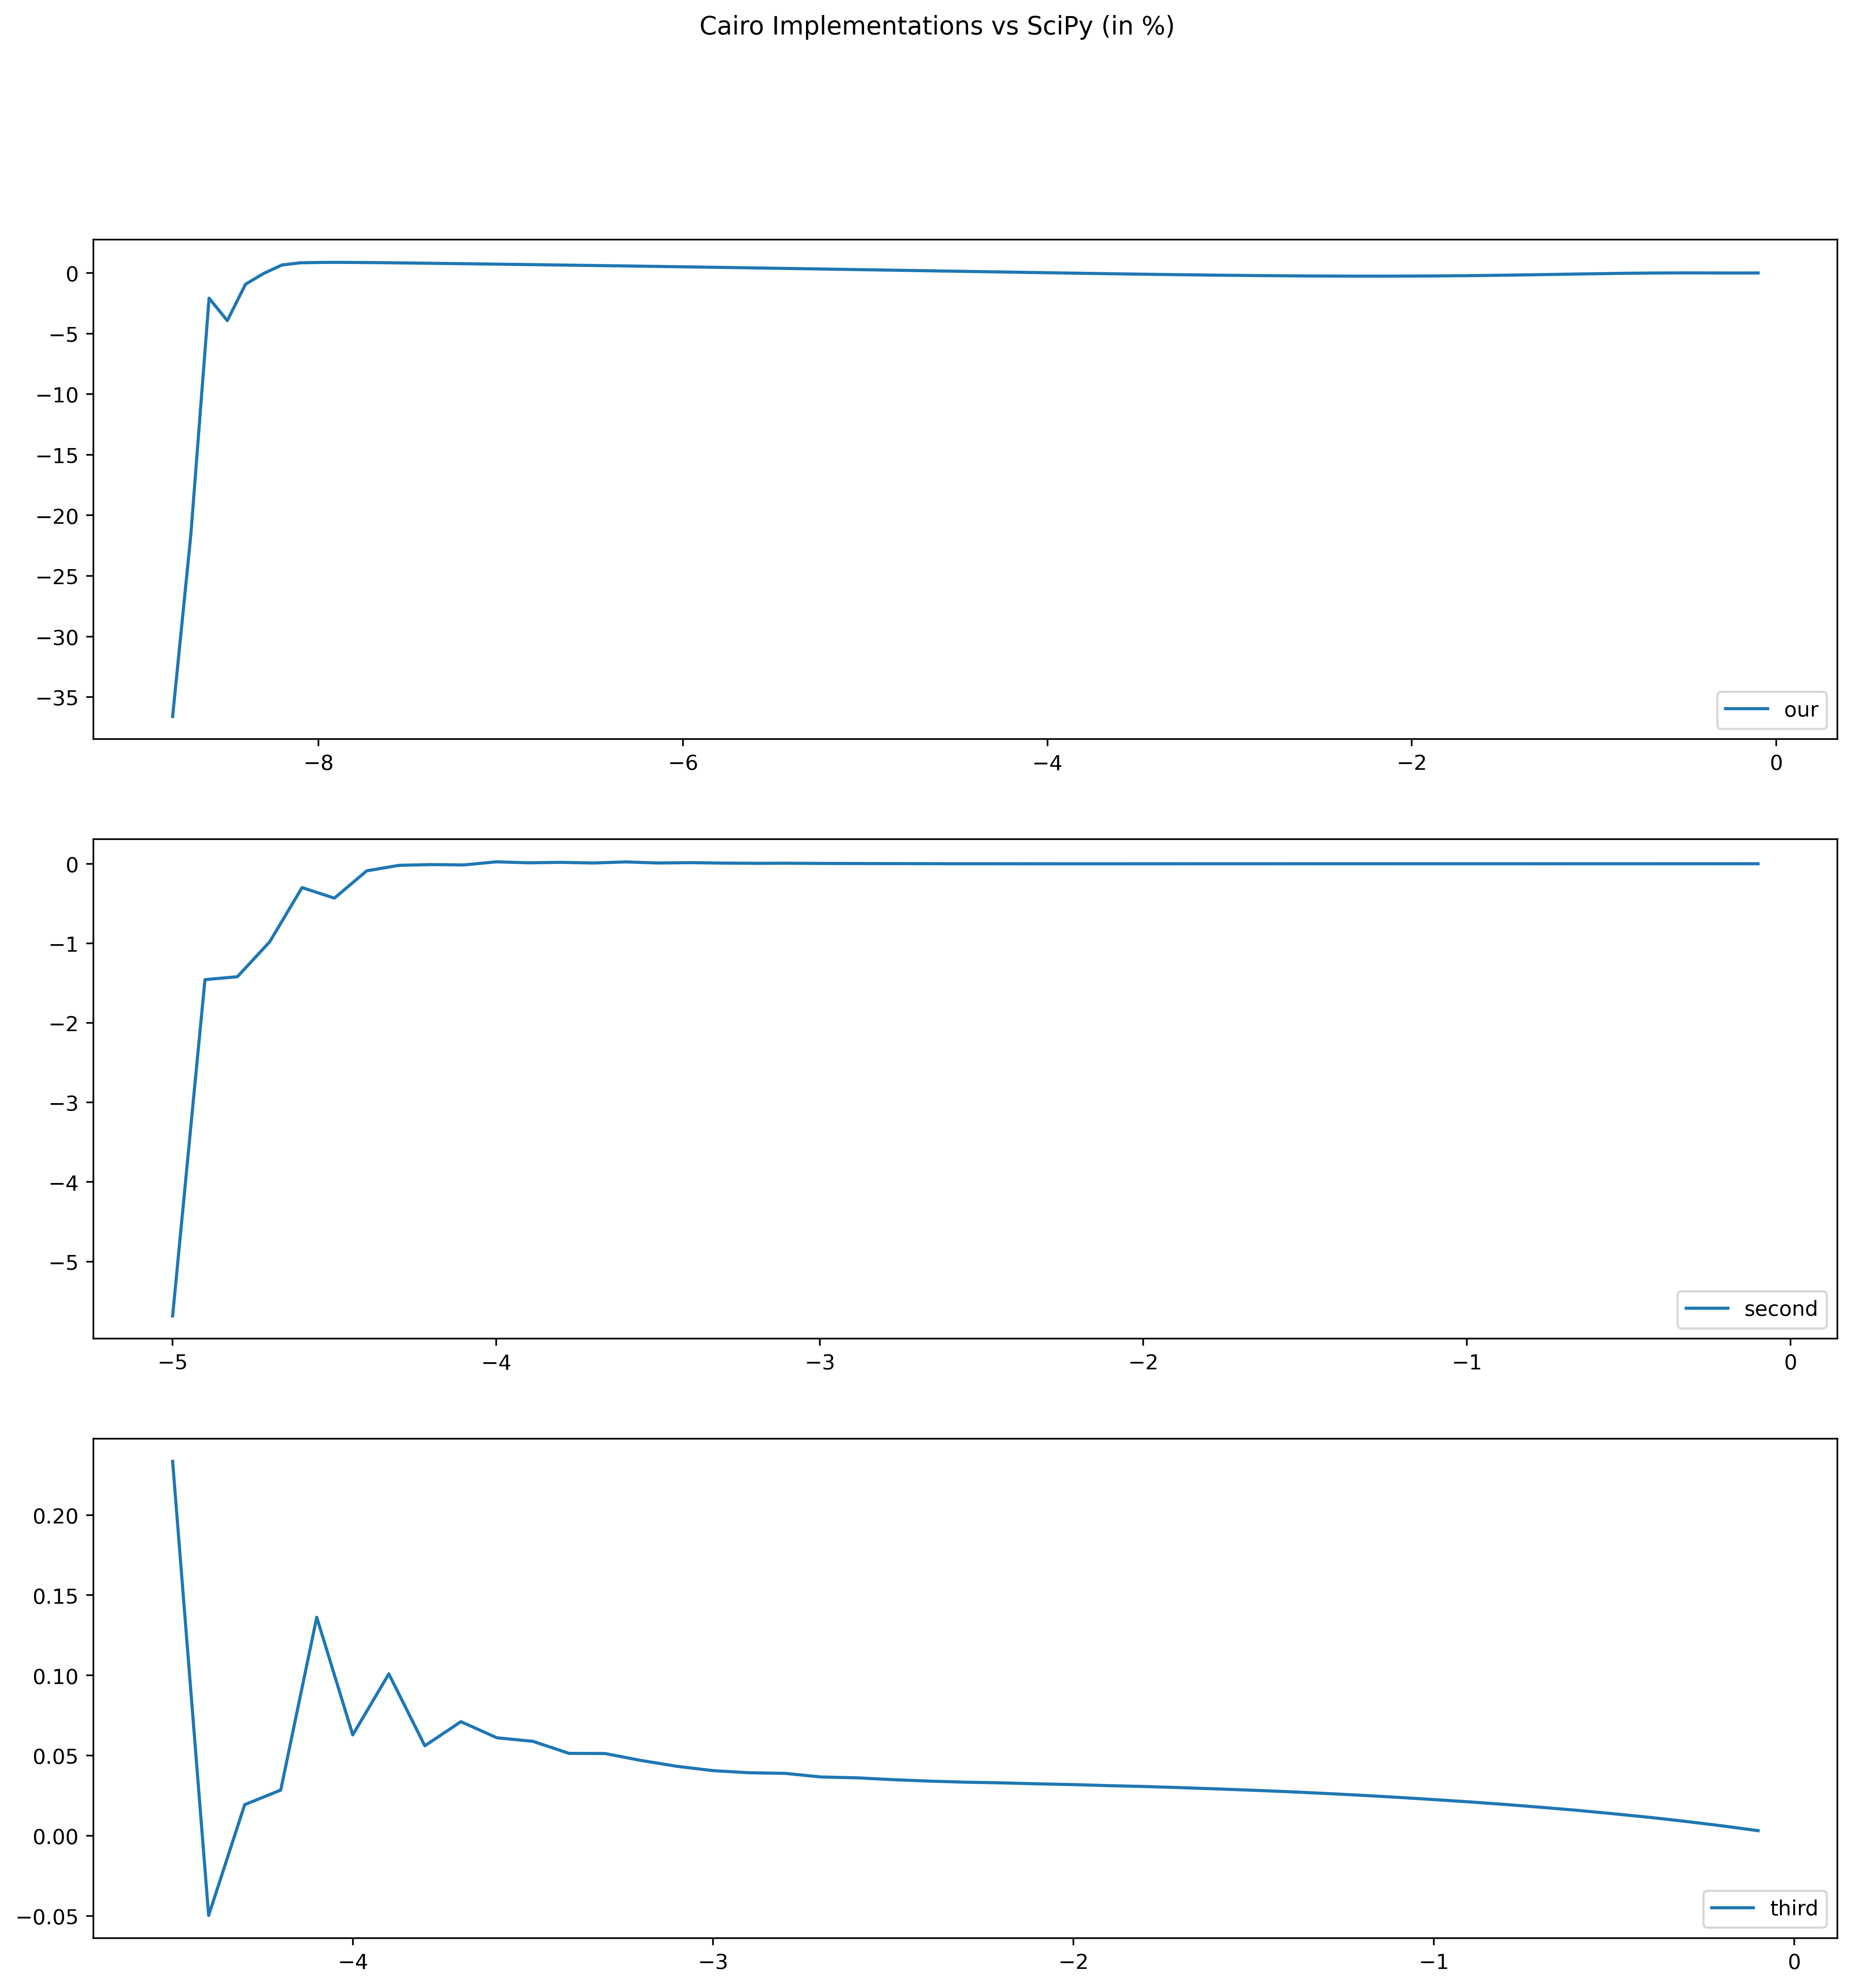

In [10]:
fig, ax = plt.subplots(ncols = 1, nrows = 3)
fig.set_dpi(400)
fig.set_size_inches(15, 15)
fig.suptitle("Cairo Implementations vs SciPy (in %)")

for cix, (ckey, cvals) in enumerate(std['cairo'].items()):
    if ckey == 'our':
        tmp = [(c / (p * 2 ** 61) - 1) * 100 for p, c in zip(std['sci_py'], cvals)]
    else:
        tmp = [(c / (p * 10 ** 27) - 1 ) * 100for p, c in zip(std['sci_py'], cvals)]
    
    tmp = list(filter(lambda x: x> -100, tmp))

    ax[cix].plot(std['xs'][len(std['xs']) - len(tmp):], tmp, label = ckey)
    ax[cix].legend(loc = 'lower right')

In [31]:
for cix, (ckey, cvals) in enumerate(std['cairo'].items()):
    if ckey == 'our':
        tmp = [(c / (p * 2 ** 61) - 1) for p, c in zip(std['sci_py'], cvals)]
    else:
        tmp = [(c / (p * 10 ** 27) - 1 ) for p, c in zip(std['sci_py'], cvals)]
    
    tmp = list(filter(lambda x: x> -1, tmp))
        
    print(f'{ckey} mean: {np.mean(tmp):%}')
    print(f'{ckey} max: {np.max(tmp):%}')
    print(f'{ckey} min: {np.min(tmp):%}')
    print('-----------------------------------------------------')

our mean: -0.546532%
our max: 0.885152%
our min: -36.603850%
-----------------------------------------------------
second mean: -0.205478%
second max: 0.024062%
second min: -5.684034%
-----------------------------------------------------
third mean: 0.039068%
third max: 0.233485%
third min: -0.049626%
-----------------------------------------------------


### Our contract only

For the purpose of including x=0

In [14]:
res_zero = await contract.testable_std_normal_cdf(x = 0).call()
res_zero = res_zero.result[0]

In [15]:
sci_py_zero = norm.cdf(0)

Text(0.5, 1.0, 'Relative diffs excluding zero values')

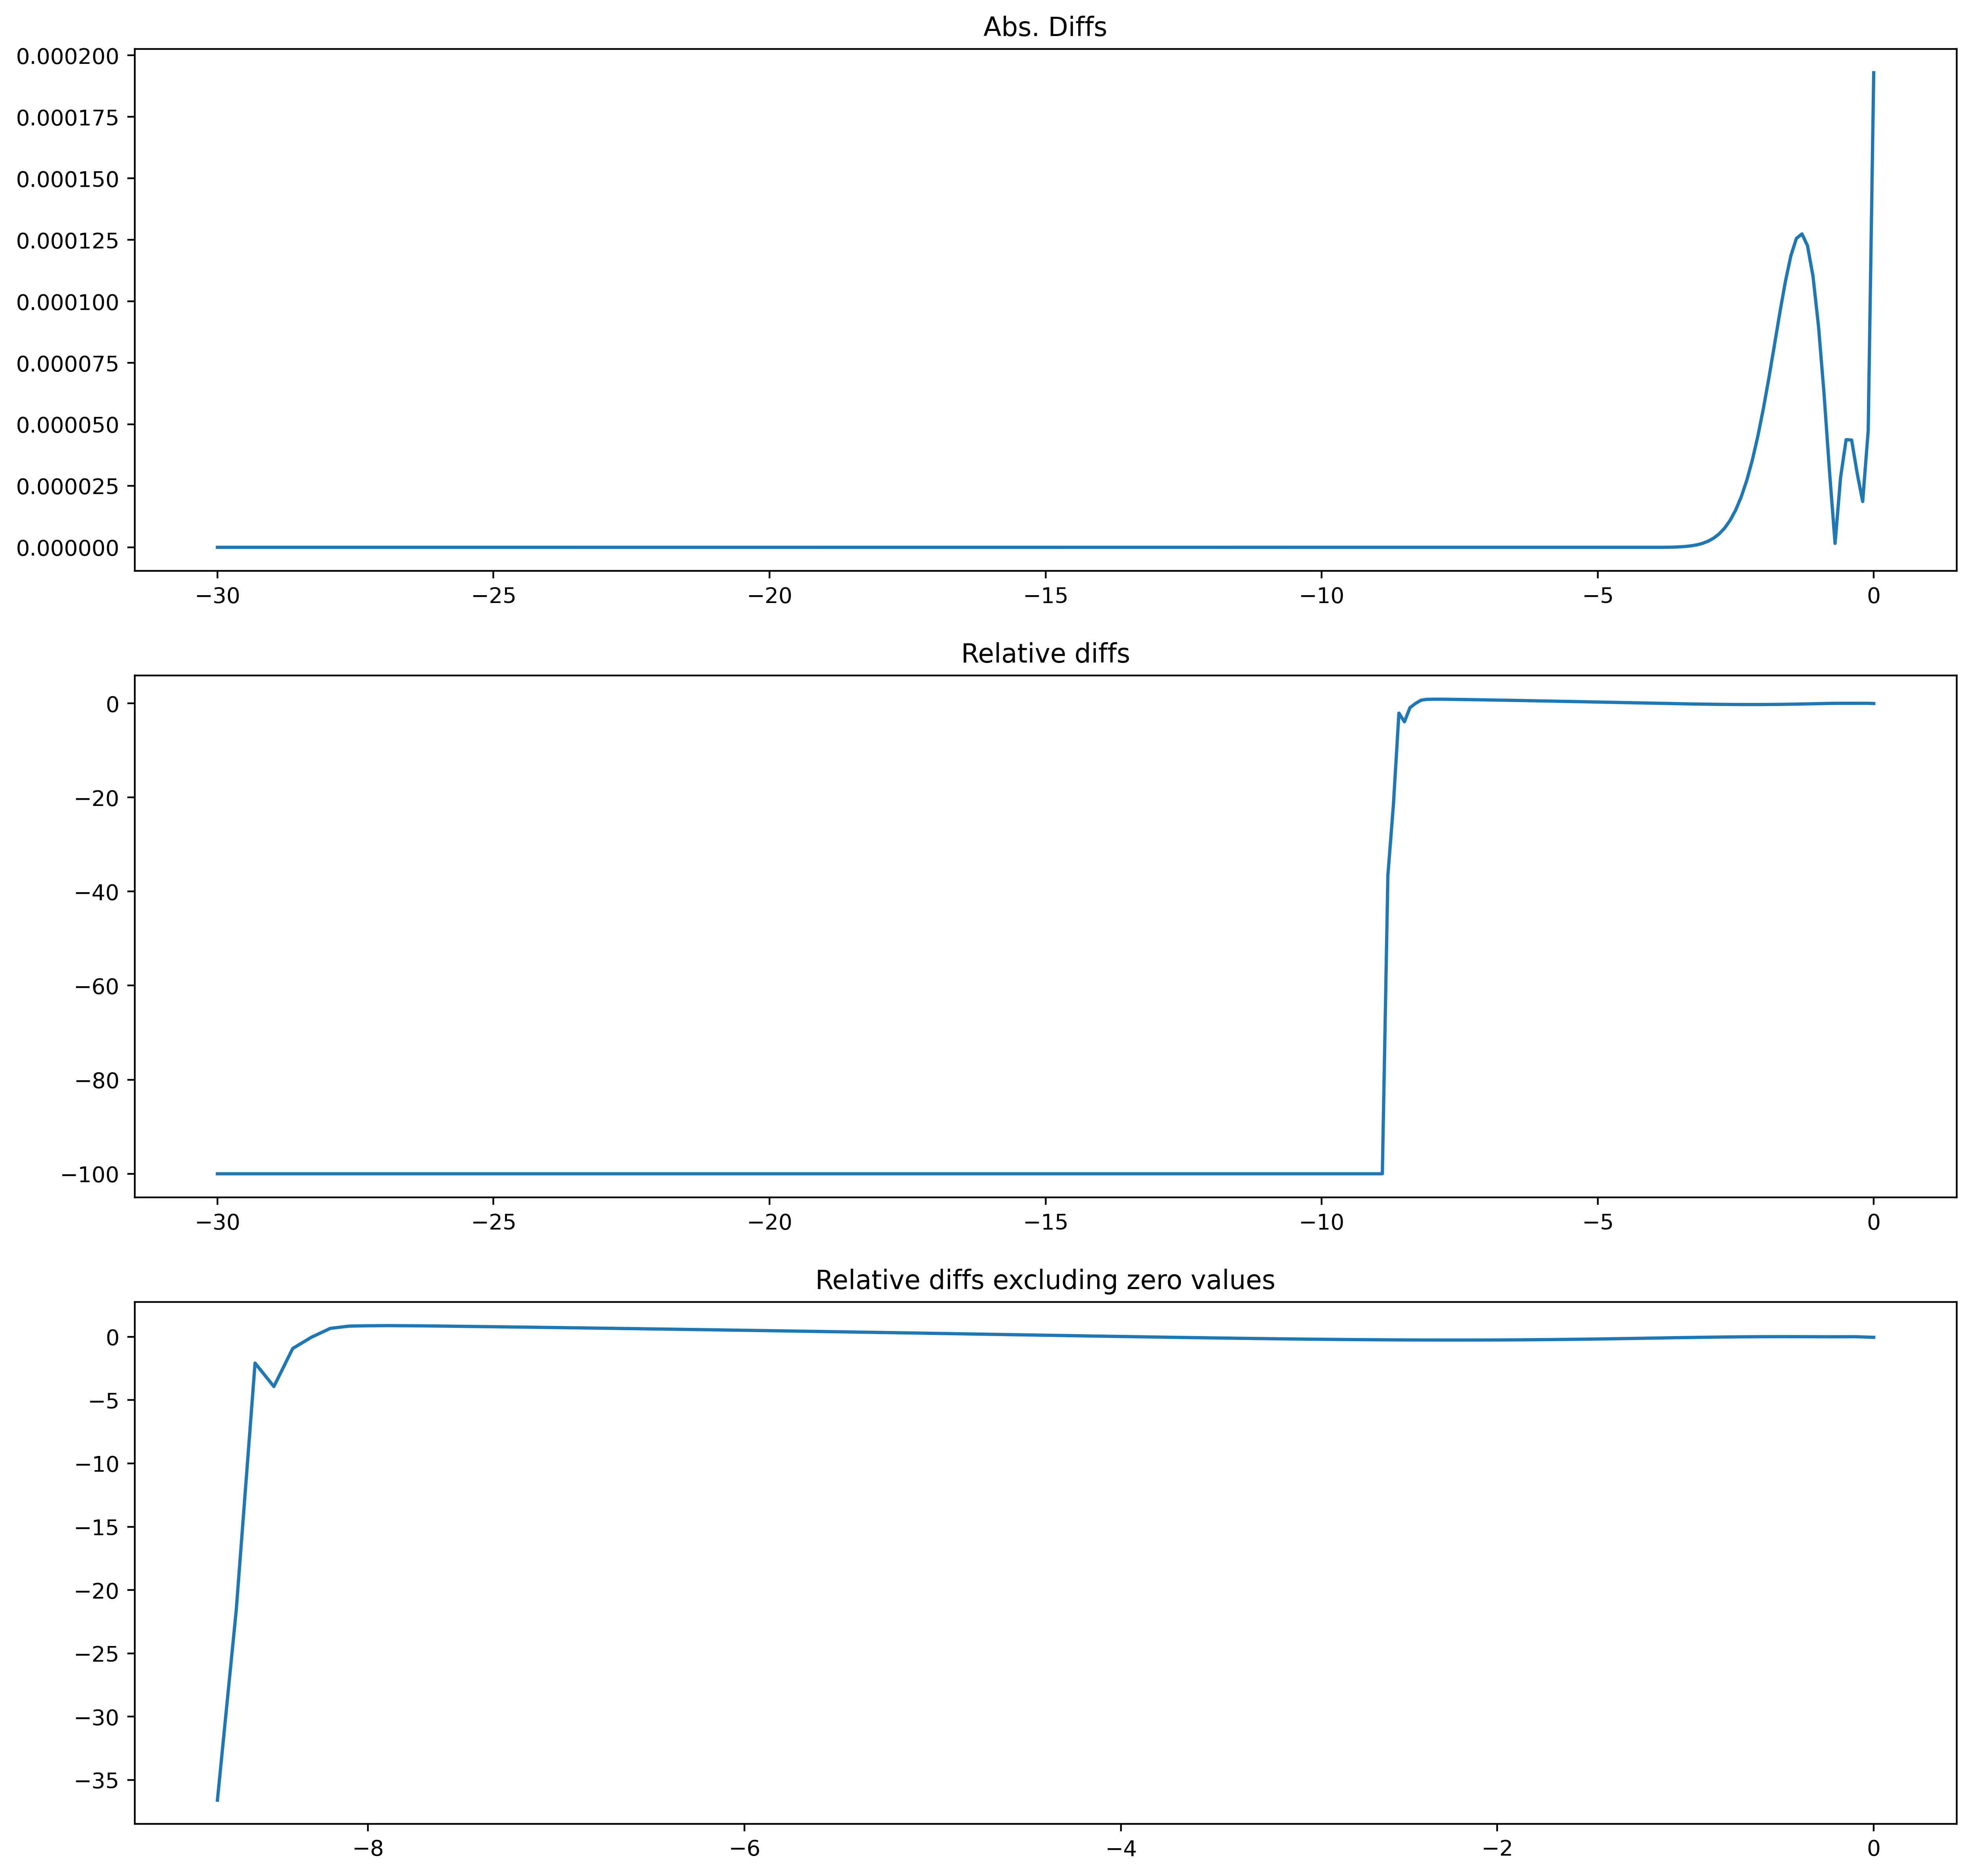

In [16]:
fig, ax = plt.subplots(ncols = 1, nrows = 3)
fig.set_dpi(400)
fig.set_size_inches(15, 15)

tmp_abs = [abs(p - (c / 2**61)) for p, c in zip(std['sci_py'] + [sci_py_zero], std['cairo']['our']+[res_zero])]
tmp_rel = [(c / (p * 2 ** 61) - 1) * 100 for p, c in zip(std['sci_py'] + [sci_py_zero], std['cairo']['our']+[res_zero])]
tmp_rel_no_zero = list(filter(lambda x: x > -100, tmp_rel))

ax[0].plot(std['xs']+[0], tmp_abs)
ax[0].set_title('Abs. Diffs')
ax[1].plot(std['xs']+[0], tmp_rel)
ax[1].set_title('Relative diffs')
ax[2].plot((std['xs']+[0])[len(std['xs']+[0]) - len(tmp_rel_no_zero):], tmp_rel_no_zero)
ax[2].set_title('Relative diffs excluding zero values')

In [17]:
print(f'Our mean: {np.mean(tmp_rel)}%')
print(f'Our max: {np.max(tmp_rel)}%')
print(f'Our min: {np.min(tmp_rel)}%')
print('-----------------------------------------------------')
print(f'Our mean without zeros: {np.mean(tmp_rel_no_zero)}%')
print(f'Our max without zeros: {np.max(tmp_rel_no_zero)}%')
print(f'Our min without zeros: {np.min(tmp_rel_no_zero)}%')

Our mean: -70.59180531815946%
Our max: 0.8851517091417849%
Our min: -100.0%
-----------------------------------------------------
Our mean without zeros: -0.5408247277078104%
Our max without zeros: 0.8851517091417849%
Our min without zeros: -36.60385017315468%


Our contract starts to return zero after after approx. -8.8, as seen below. 

In [18]:
std['cairo']['our'][200:220]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 3, 9, 21, 51, 120, 279, 639]

In [25]:
std['xs'][std['cairo']['our'].index(1)]

-8.8

#### As seen from the plots, our contract might suffer from slightly higher errors, however, other contracts will return 0 or  1 sooner the ours. 